In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
base_dir = Path("C:/Users/archa/Desktop/Databricks/Data")
raw_path = base_dir / "raw"
processed_path = base_dir / "processed"
staging_path = processed_path / "staging"
failed_path = processed_path / "qc_failed"
gold_path = processed_path / "gold"

# Create dirs if needed
for path in [staging_path, failed_path, gold_path]:
    path.mkdir(parents=True, exist_ok=True)

In [12]:
# Load QC Passed Staging Data
staging_df = pd.read_parquet(staging_path / "claims_staging.parquet")

# Enrich: Add derived fields (e.g., Claim Month, Company Group)
staging_df['CLAIM_MONTH'] = staging_df['DATE'].dt.to_period('M').astype(str)
staging_df['COMPANY_GROUP'] = staging_df['COMPANY'].replace({
    'Aetna': 'Group A',
    'Kaiser': 'Group B',
    'Blue Cross': 'Group A',
    'United': 'Group B'
})

# Aggregate: Total claim amount per month per state
gold_df = (
    staging_df
    .groupby(['CLAIM_MONTH', 'ACCIDENT_STATE'])
    .agg(
        TOTAL_CLAIMS=('AMOUNT', 'sum'),
        AVERAGE_CLAIM=('AMOUNT', 'mean'),
        CLAIM_COUNT=('AMOUNT', 'count')
    )
    .reset_index()
)


In [15]:
print(f"✅ Loaded staging data: {staging_df.shape[0]} rows")
print("✅ Derived CLAIM_MONTH and COMPANY_GROUP fields added")


✅ Loaded staging data: 100 rows
✅ Derived CLAIM_MONTH and COMPANY_GROUP fields added


In [13]:
# Save Gold Table (Aggregated)
gold_path = processed_path / "gold"
gold_path.mkdir(parents=True, exist_ok=True)

gold_df.to_parquet(gold_path / "claims_gold.parquet", index=False)
gold_df.to_csv(gold_path / "claims_gold.csv", index=False)

print("✅ Staging → Gold layer transformation complete.")


✅ Staging → Gold layer transformation complete.


C:\Users\archa\AppData\Local\Temp\ipykernel_24920\452699477.py:17: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
c:\Users\archa\Desktop\Databricks\Claims_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\archa\Desktop\Databricks\Claims_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


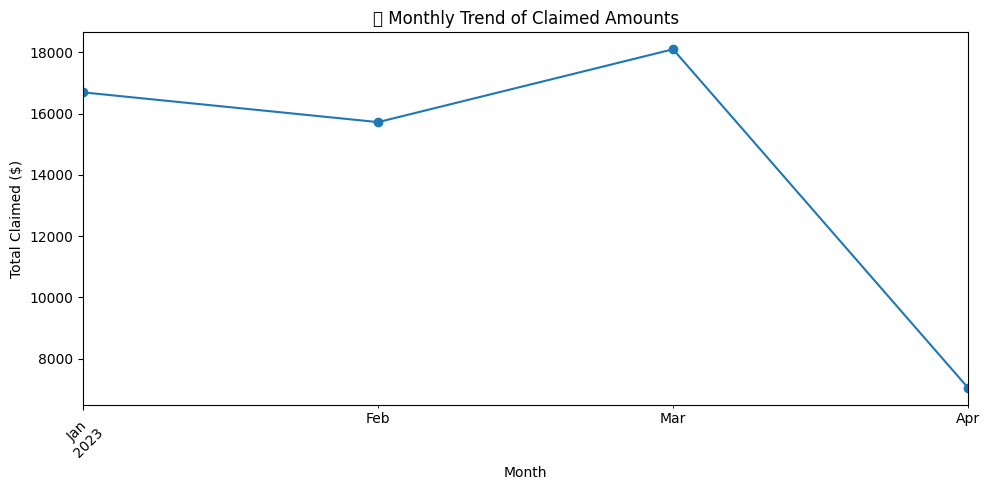

In [25]:
# Convert to datetime
staging_df['DATE'] = pd.to_datetime(staging_df['DATE'], errors='coerce')

# Extract month
staging_df['MONTH'] = staging_df['DATE'].dt.to_period('M')

# Monthly trend: Total amount per month
monthly_trend = staging_df.groupby('MONTH')['AMOUNT'].sum()

# Plot
import matplotlib.pyplot as plt
monthly_trend.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("📅 Monthly Trend of Claimed Amounts")
plt.xlabel("Month")
plt.ylabel("Total Claimed ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


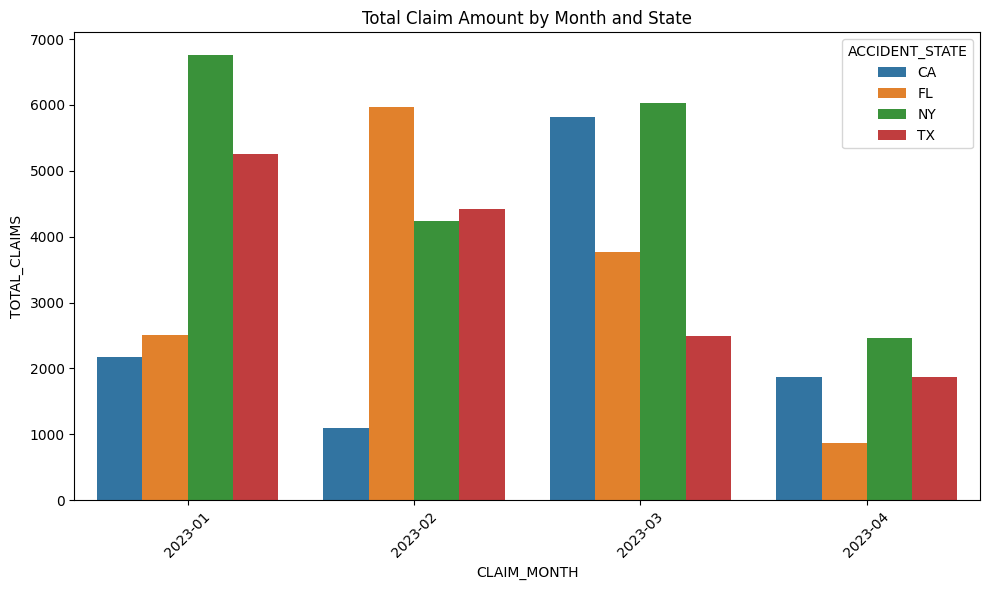

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(data=gold_df, x='CLAIM_MONTH', y='TOTAL_CLAIMS', hue='ACCIDENT_STATE')
plt.title("Total Claim Amount by Month and State")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
gold_df = (
    staging_df
    .groupby(['CLAIM_MONTH', 'ACCIDENT_STATE'])
    .agg(
        TOTAL_CLAIMS=('AMOUNT', 'sum'),
        AVERAGE_CLAIM=('AMOUNT', 'mean'),
        CLAIM_COUNT=('AMOUNT', 'count')
    )
    .reset_index()
)


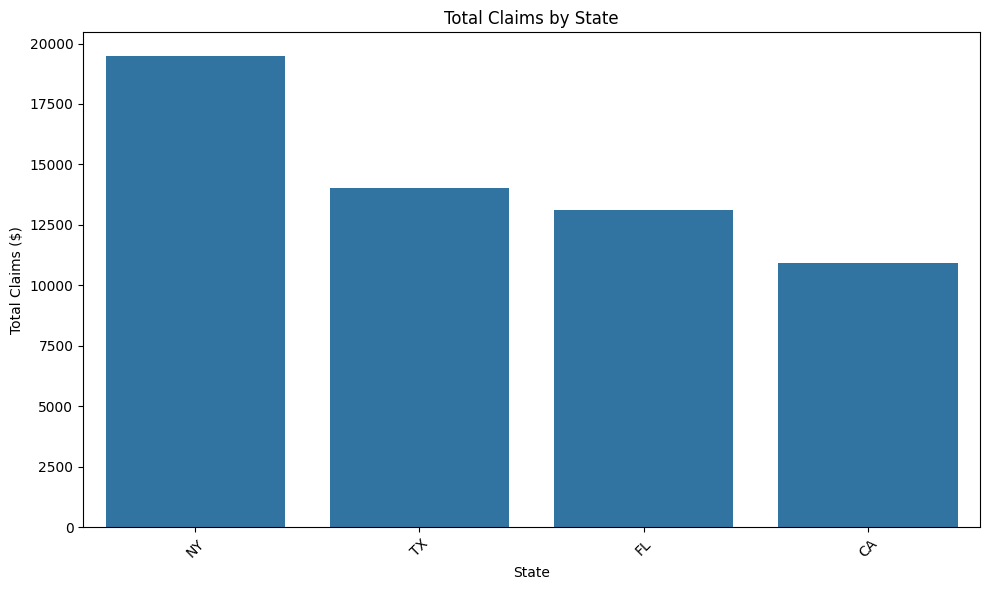

In [23]:
# Aggregate total by state
state_claims = gold_df.groupby('ACCIDENT_STATE')['TOTAL_CLAIMS'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=state_claims.index, y=state_claims.values)
plt.title("Total Claims by State")
plt.xlabel("State")
plt.ylabel("Total Claims ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ Save the plot
fig.savefig(gold_path / "claims_trends_by_state.png", dpi=300)
plt.show()

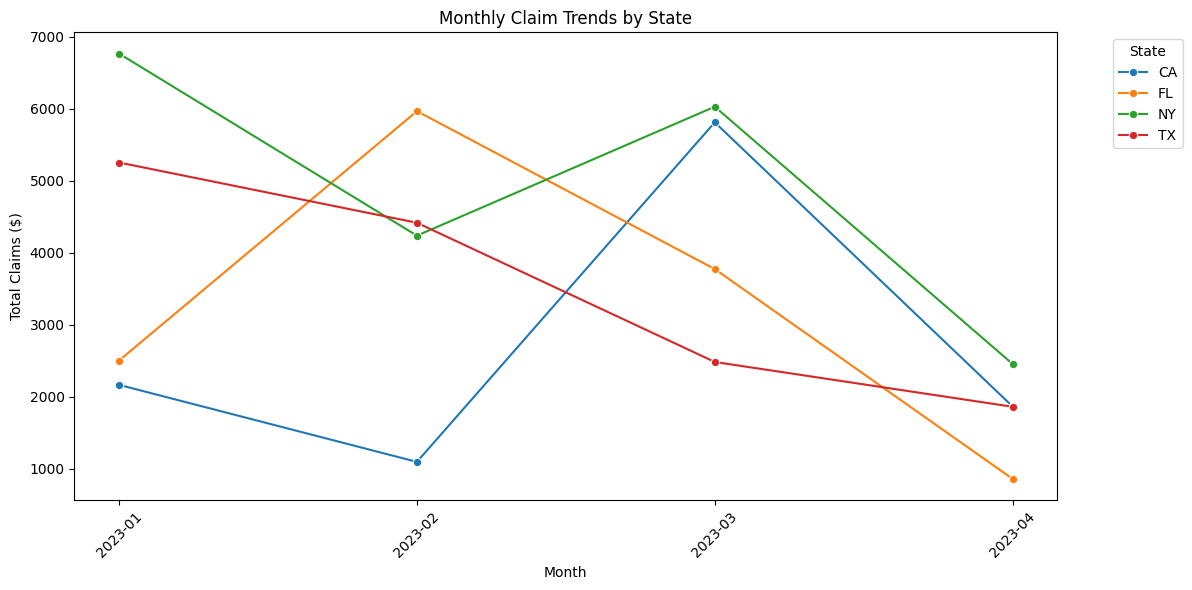

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=gold_df, x='CLAIM_MONTH', y='TOTAL_CLAIMS', hue='ACCIDENT_STATE', marker="o")
plt.title("Monthly Claim Trends by State")
plt.xlabel("Month")
plt.ylabel("Total Claims ($)")
plt.xticks(rotation=45)
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [24]:
print(gold_df.head())
gold_df.info()


  CLAIM_MONTH ACCIDENT_STATE  TOTAL_CLAIMS  AVERAGE_CLAIM  CLAIM_COUNT
0     2023-01             CA          2167     433.400000            5
1     2023-01             FL          2505     626.250000            4
2     2023-01             NY          6765     520.384615           13
3     2023-01             TX          5253     583.666667            9
4     2023-02             CA          1098     549.000000            2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CLAIM_MONTH     16 non-null     object 
 1   ACCIDENT_STATE  16 non-null     object 
 2   TOTAL_CLAIMS    16 non-null     int32  
 3   AVERAGE_CLAIM   16 non-null     float64
 4   CLAIM_COUNT     16 non-null     int64  
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 708.0+ bytes


In [17]:
gold_df.to_parquet(gold_path / "claims_gold.parquet", index=False)
gold_df.to_csv(gold_path / "claims_gold.csv", index=False)
print(f"✅ Gold table saved: {gold_df.shape[0]} rows")


✅ Gold table saved: 16 rows
